## **Training Graph Neural Networks with a Custom `ModelAssessment` Class**

In this notebook, we detail the various steps involved in training the **Graph Neural Network** (GNN) architectures we reimplemented using `PyTorch`, as well as the structure of the *model selection* and *risk assessment* pipeline.


In [ ]:
import sys
import random
import time
import numpy as np
sys.path.append('../datasets')
import torch 
import itertools
from tqdm import tqdm
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

from datasets.manager import IMDBBinary, DD
from utils.utils import get_adjacency_and_features, visualise_graph
from datasets.dataset import *
from Pipeline.train import Train
from src.models import GCN, GAT, GIN, GraphSAGE
from datasets.dataloader import DataLoader

from Pipeline.Model_Assessment import ModelAssessment, plot_gnn_comparison
from Pipeline.Model_Selection import ModelSelection, grid


### **Data Import**

We will train our GNN architectures on two datasets: **IMDB-Binary** and **D&D**.

In the following cell, the `IMDB` and `DD` objects are **dataset managers**—custom objects designed to handle and manipulate the data from each dataset. These classes offer several attributes for flexible dataset handling:

- `.dataset`: gives direct access to the raw dataset object.
- `.splits`: provides access to predefined data splits for performing **K-Fold Cross-Validation**, generated with stratification to preserve class distribution. These splits allow for a centralized and consistent handling of Train/Validation/Test sets across all GNN architectures.

The underlying dataset objects themselves also come with useful attributes and methods:

- `.get_data()`: returns the node feature matrices, edge indices, and edge features (if any) for all graphs in the dataset.
- `.get_targets()`: provides the graph-level labels for classification.


In [2]:
## Chargement des datasets
IMDB = IMDBBinary()
DD = DD()

> 📌 The dataset splits are **precomputed** (with stratification enabled) to ensure consistent and fair model comparisons across different architectures.

To access a specific fold:

```python
dataset.splits[<fold_index>]["<Fold Type>"][0]

In [3]:
idxs_train_0 = IMDB.splits[0]["model_selection"][0]["train"]
idxs_test_0 = IMDB.splits[0]["test"]
idxs_validation_0 = IMDB.splits[0]["model_selection"][0]["validation"]

train_data = GraphDatasetSubset(IMDB.dataset.get_data(), idxs_train_0)
val_data = GraphDatasetSubset(IMDB.dataset.get_data(), idxs_validation_0)
test_data = GraphDatasetSubset(IMDB.dataset.get_data(), idxs_test_0)

### **Dataset Visualization**

We can visually inspect the individual graphs within our datasets using the `visualise_graph()` function.

A graph printed as:

In [4]:
x_DD, y_DD = DD.dataset.get_data(), DD.dataset.get_targets()

In [5]:
node8 = x_DD[8]
node8

GraphData(x=torch.Size([377, 89]), edge_index=torch.Size([2, 894]))

`GraphData(x=torch.Size([18, 1]), edge_index=torch.Size([2, 153]))` represents:

- **18 nodes**, each with feature vectors of dimension 1,
- **153 edges**, defined via the `edge_index` matrix (each column represents an edge between two nodes).

The `visualise_graph()` function allows easy visualization by specifying the index of the graph in the dataset. Internally, it uses PyTorch Geometric’s `to_networkx` to convert the graph into a NetworkX object, which is then plotted using standard layout algorithms.


/Users/tomrossa/Documents/MVA/MVA S2/Graphical Models/MVA_Graphical_Models/my_env/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


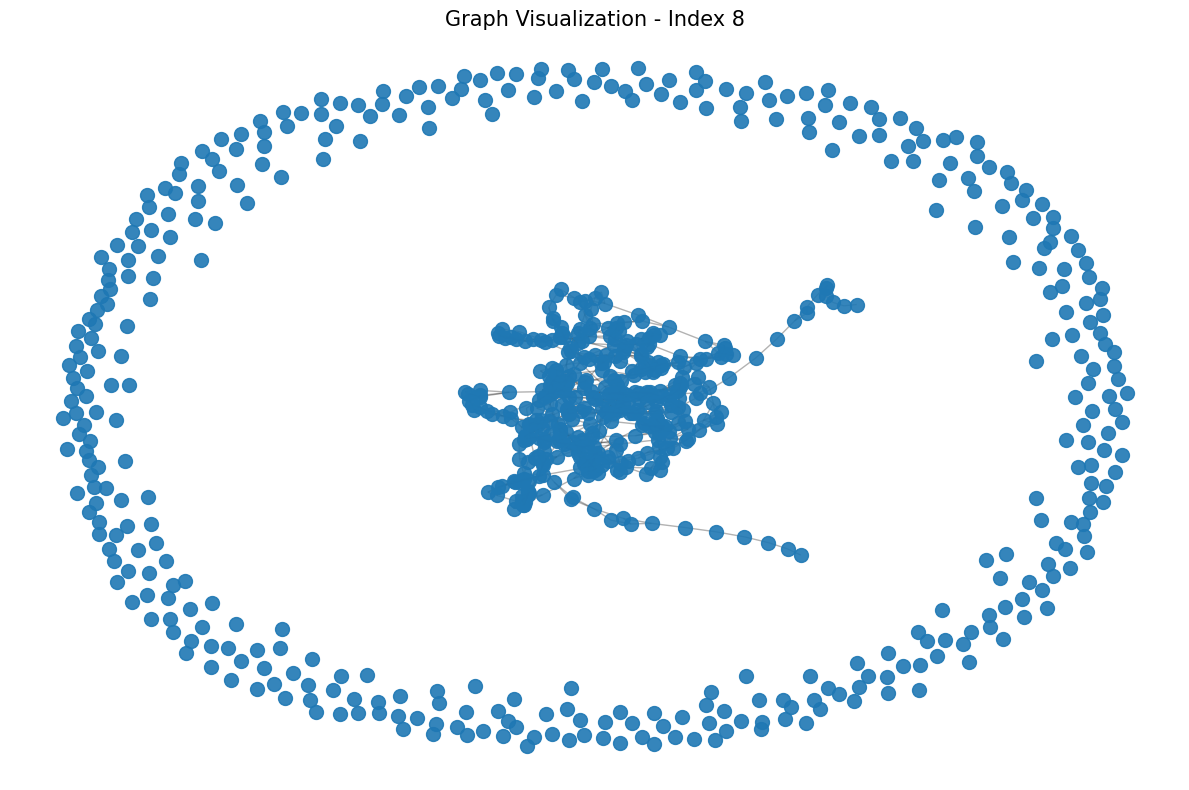

In [6]:
visualise_graph(8, x_DD)

To obtain the graph’s adjacency matrix and its corresponding node features, we use:

```python
get_adjacency_and_features()
```

This function returns the normalized adjacency matrix and the node feature matrix. Node features are often simple one-hot encodings (e.g., atom type labels in molecular datasets), but can also encode more complex attributes.

In [7]:
adjency_mat, feature_vect = get_adjacency_and_features(node8)
print("Adjency matrix:\n")
print(adjency_mat)
print("Feature vector: \n")
print(feature_vect)

Adjency matrix:

tensor([[0.1667, 0.1667, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1667, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])
Feature vector: 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


### **Training GNNs with Nested Cross-Validation**

In this section, we outline the training procedure for our GNN architectures using a custom training pipeline. All architectures (GCN, GAT, GIN, GraphSAGE, and a baseline MLP) were reimplemented from scratch using PyTorch. The experimental training and evaluation framework is inspired by the work of [Federico et al., 2022](https://arxiv.org/abs/1912.09893), and is designed to ensure **fair comparison** across models.

Before launching training, we define a configuration dictionary specifying:

- The **model architecture** to train → GCN, GAT, GIN, GraphSAGE, Baseline MLP.
- The **dataset** to use → D&D, PROTEINS, IMDB-BINARY.
- Whether to enable **CUDA** (GPU acceleration).
- A **random seed** for reproducibility.
- The number of **folds** for K-Fold Cross-Validation (used both for model selection and risk assessment).

This same configuration also includes **hyperparameters**, which can be given as either:
- a **single value**, or
- a **list of values** (for automatic grid search during cross-validation).

The most important tunable hyperparameters include:

- *Pooling Type*: Defines how node representations are aggregated across layers (e.g., `mean`, `max`, `sum`).
- *Learning Rate*: Step size for gradient descent updates.
- *Number of Epochs*: Total training iterations over the dataset.
- *Number of Convolutional Layers*: Depth of the GNN.
- *Embedding Dimension*: Dimensionality of node embeddings.
- *Weight Decay*: L2 regularization strength (helps prevent overfitting).
- *Batch Size*: Number of graphs processed per batch.
- *Dropout Rate*: Proportion of neurons randomly dropped during training.
- *...etc.*

In [8]:
params_list = {"model_type": "GAT",  # "GCN", "GAT", "GIN", "GraphSAGE"
               "n_graph_subsampling": 0, # the number of running graph subsampling each train graph data run subsampling 5 times: increasing graph data 5 times
               "graph_node_subsampling": True, # TRUE: removing node randomly to subsampling and augmentation of graph dataset \n'+
                # FALSE: removing edge randomly to subsampling and augmentation of graph dataset
               "graph_subsampling_rate": 0.2, # graph subsampling rate
               "dataset": "IMDB", 
               "pooling_type": "mean", 
               "seed": 42,
               "n_folds": 10, 
               "cuda": True, 
               "lr": [0.001, 0.01], 
               "epochs": 1, 
               "weight_decay":5e-4,
               "batch_size": 32, 
               "dropout": 0, # dropout rate of layer
               "num_lay": 2, 
               "num_agg_layer": 2, # the number of graph aggregation layers
               "hidden_agg_lay_size": 32, # size of hidden graph aggregation layer
               "fc_hidden_size": 128, # size of fully-connected layer after readout
               "threads":10, # how many subprocesses to use for data loading
               "random_walk":True,
               "walk_length": 20, # walk length of random walk, 
               "num_walk": 10, # num of random walk
               "p": 0.65, # Possibility to return to the previous vertex, how well you navigate around
               "q": 0.35, # Possibility of moving away from the previous vertex, how well you are exploring new places
               "print_logger": 10,  # printing rate
               "eps":0.0, # for GIN only
               }

### **Hyperparameter Grid Construction**

The `grid` object is used to store all hyperparameter configurations during training. It also enables the generation of hyperparameter grids to be explored during the **model selection** phase.

This is done via the `.get_combinations()` method, which automatically creates all combinations of specified hyperparameter values.

In [9]:
dic = {"lr" : params_list["lr"], "num_lay" : [1, 2], "hidden_agg_lay_size" : [16, 32, 64]}
grille = grid(dic)

print("Grid search: \n")
grille.get_combinations()

Grid search: 



[{'lr': 0.001, 'num_lay': 1, 'hidden_agg_lay_size': 16},
 {'lr': 0.001, 'num_lay': 1, 'hidden_agg_lay_size': 32},
 {'lr': 0.001, 'num_lay': 1, 'hidden_agg_lay_size': 64},
 {'lr': 0.001, 'num_lay': 2, 'hidden_agg_lay_size': 16},
 {'lr': 0.001, 'num_lay': 2, 'hidden_agg_lay_size': 32},
 {'lr': 0.001, 'num_lay': 2, 'hidden_agg_lay_size': 64},
 {'lr': 0.01, 'num_lay': 1, 'hidden_agg_lay_size': 16},
 {'lr': 0.01, 'num_lay': 1, 'hidden_agg_lay_size': 32},
 {'lr': 0.01, 'num_lay': 1, 'hidden_agg_lay_size': 64},
 {'lr': 0.01, 'num_lay': 2, 'hidden_agg_lay_size': 16},
 {'lr': 0.01, 'num_lay': 2, 'hidden_agg_lay_size': 32},
 {'lr': 0.01, 'num_lay': 2, 'hidden_agg_lay_size': 64}]

In [10]:
## Initialisation de la grille d'hyperparamètres
grille = grid(params_list)

### **Training Pipeline Overview**

Now that we’ve defined the training configuration—including the model architecture, dataset, and hyperparameter grid—we can launch the training process according to the experimental framework introduced in the reference paper:

![Experimental Framework](Exp.png)

---
#### **Train**
The `Train` class manages the full training and evaluation pipeline for Graph Neural Networks (GCN, GAT, GIN, GraphSAGE) using PyTorch.

#### What it does:

- Loads the dataset (`IMDB` or `DD`) and extracts features/labels.
- Instantiates the selected GNN model based on user-defined parameters.
- Sets up the optimizer (Adam), learning rate scheduler, and data loaders.
- Runs training over multiple epochs, with optional early stopping.
- Evaluates model performance (accuracy) during or after training.

#### Key methods:

- `get_model()` – Instantiates the chosen GNN architecture  
- `train()` – Runs a training epoch  
- `evaluate()` – Computes test accuracy  
- `fit()` – Full training loop with early stopping support

---

#### **Model Selection**

The `Model_Selection` class performs **cross-validation-based hyperparameter tuning** for a given model and dataset. It takes the following arguments:

- The full dataset object.
- A list of training indices (i.e., the subset of graphs for the current training fold).
- The hyperparameter grid to explore.
- `Random_Search` (optional): if set to `True`, the class performs **randomized search** instead of exhaustive grid search via the `RandomSearch` method.

This class returns the best-performing hyperparameter combination based on cross-validation performance within the training set.

---

#### **Model Assessment**

To perform **Nested Cross-Validation** (i.e., simultaneous model selection and risk assessment), simply initialize the `ModelAssessment` class with:

- The name of the dataset to train on.
- The list of training parameters defined earlier.
- The `RandomSearch` option to toggle between full grid search and random search.

Once initialized, call the `.assess()` method to automatically run all steps of training, cross-validation, and evaluation.

This nested procedure ensures **unbiased performance estimation**, as model selection is performed independently within each outer fold of the cross-validation loop.


In [11]:
## Exemple Training

ModelAssessment__ = ModelAssessment(IMDB, params_list, random_search=False)
mean, std_dev = ModelAssessment__.assess()

print(f"Accuracy Mean over 10 folds: {mean}\n")
print(f"Accuracy Std Dev over 10 folds: {std_dev}\n")

  0%|          | 0/10 [00:00<?, ?it/s]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 6.64 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 4.83 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 10%|█         | 1/10 [00:20<03:02, 20.30s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 6.17 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 9.32 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.06 seconds 



Average training time per epoch: 0.01 seconds 



 20%|██        | 2/10 [00:48<03:19, 24.91s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 8.84 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 4.25 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 30%|███       | 3/10 [01:12<02:50, 24.32s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 8.91 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 9.11 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 40%|████      | 4/10 [01:42<02:40, 26.76s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 9.03 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 5.10 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 50%|█████     | 5/10 [02:08<02:11, 26.31s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 5.26 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 12.58 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 60%|██████    | 6/10 [02:36<01:47, 26.88s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 7.60 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 6.23 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.04 seconds 



 70%|███████   | 7/10 [02:59<01:16, 25.60s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 8.15 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 9.71 seconds 



Average training time per epoch: 0.06 seconds 



Average training time per epoch: 0.02 seconds 



Average training time per epoch: 0.01 seconds 



 80%|████████  | 8/10 [03:30<00:54, 27.37s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 7.34 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 10.36 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 90%|█████████ | 9/10 [03:58<00:27, 27.81s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 4.16 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 6.16 seconds 



Average training time per epoch: 0.02 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



100%|██████████| 10/10 [04:19<00:00, 25.99s/it]

Accuracy Mean over 10 folds: 50.0

Accuracy Std Dev over 10 folds: 0.0



#### **Launching the Full Benchmark Procedure**

In this final step, we run the training process for **each GNN architecture** across the selected datasets using two different hyperparameter selection strategies:

- **Grid Search**: Exhaustively evaluates all possible hyperparameter combinations.
- **Random Search**: Samples a subset of random combinations from the hyperparameter space.

This cell serves as a practical **example of how to launch the full benchmark pipeline**, allowing us to compare the performance of all models under both tuning strategies.

The results from these runs will be used for performance comparison and analysis in the next section.


In [12]:
## Grid search
means_acc_1 = []
std_acc_1 = []

ModelAssessmentGCN = ModelAssessment(IMDB, params_list, random_search=False)
mean, std = ModelAssessmentGCN.assess()
means_acc_1.append(mean)
std_acc_1.append(std)

params_list["model_type"] = "GAT"
ModelAssessmentGAT = ModelAssessment(IMDB, params_list, random_search=False)
mean, std = ModelAssessmentGAT.assess()
means_acc_1.append(mean)
std_acc_1.append(std)

params_list["model_type"] = "GIN"
ModelAssessmentGIN = ModelAssessment(IMDB, params_list, random_search=False)
mean, std = ModelAssessmentGIN.assess()
means_acc_1.append(mean)
std_acc_1.append(std)

params_list["model_type"] = "GraphSAGE"
ModelAssessmentGraphSAGE = ModelAssessment(IMDB, params_list, random_search=False)
mean, std = ModelAssessmentGraphSAGE.assess()
means_acc_1.append(mean)
std_acc_1.append(std)

## RandomSearch

mean_acc_2 = []
std_acc_2 = []

params_list["model_type"] = "GCN"
ModelAssessmentGCN = ModelAssessment(IMDB, params_list, random_search=True)
mean, std = ModelAssessmentGCN.assess()
mean_acc_2.append(mean)
std_acc_2.append(std)

params_list["model_type"] = "GAT"
ModelAssessmentGAT = ModelAssessment(IMDB, params_list, random_search=True)
mean, std = ModelAssessmentGAT.assess()
mean_acc_2.append(mean)
std_acc_2.append(std)

params_list["model_type"] = "GIN"
ModelAssessmentGIN = ModelAssessment(IMDB, params_list, random_search=True)
mean, std = ModelAssessmentGIN.assess()
mean_acc_2.append(mean)
std_acc_2.append(std)

params_list["model_type"] = "GraphSAGE"
ModelAssessmentGraphSAGE = ModelAssessment(IMDB, params_list, random_search=True)
mean, std = ModelAssessmentGraphSAGE.assess()
mean_acc_2.append(mean)
std_acc_2.append(std)

  0%|          | 0/10 [00:00<?, ?it/s]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 7.73 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 7.61 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 10%|█         | 1/10 [00:24<03:40, 24.46s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 6.39 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 6.98 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 20%|██        | 2/10 [00:47<03:11, 23.89s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 11.03 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 8.54 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 30%|███       | 3/10 [01:16<03:02, 26.04s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 7.18 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 7.36 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 40%|████      | 4/10 [01:38<02:25, 24.29s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 7.22 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 10.37 seconds 



Average training time per epoch: 0.02 seconds 



Average training time per epoch: 0.02 seconds 



Average training time per epoch: 0.01 seconds 



 50%|█████     | 5/10 [02:09<02:13, 26.69s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 7.99 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 6.32 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 60%|██████    | 6/10 [02:35<01:46, 26.58s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 9.80 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 10.66 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 70%|███████   | 7/10 [03:07<01:25, 28.36s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 4.64 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 6.71 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.02 seconds 



 80%|████████  | 8/10 [03:29<00:52, 26.26s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 9.30 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 8.86 seconds 



Average training time per epoch: 0.02 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.02 seconds 



 90%|█████████ | 9/10 [03:58<00:27, 27.29s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 4.26 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.91 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



  0%|          | 0/10 [00:00<?, ?it/s]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.85 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 7.08 seconds 



Average training time per epoch: 0.03 seconds 



Average training time per epoch: 0.02 seconds 



Average training time per epoch: 0.01 seconds 



 10%|█         | 1/10 [00:23<03:31, 23.52s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 4.91 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 4.99 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 20%|██        | 2/10 [00:42<02:45, 20.69s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 6.44 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 4.73 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.23 seconds 



Average training time per epoch: 0.01 seconds 



 30%|███       | 3/10 [01:01<02:21, 20.20s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 6.61 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 6.66 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 40%|████      | 4/10 [01:24<02:07, 21.26s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 7.61 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 4.13 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 50%|█████     | 5/10 [01:44<01:43, 20.65s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 4.08 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.97 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 60%|██████    | 6/10 [01:58<01:14, 18.51s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 4.13 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 4.18 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 70%|███████   | 7/10 [02:14<00:52, 17.51s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 4.47 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 8.63 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 80%|████████  | 8/10 [02:36<00:37, 18.95s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.73 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 6.88 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 90%|█████████ | 9/10 [03:03<00:21, 21.68s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 10.61 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 6.73 seconds 



Average training time per epoch: 0.03 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



  0%|          | 0/10 [00:00<?, ?it/s]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.33 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 7.20 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 10%|█         | 1/10 [00:19<02:55, 19.45s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 6.11 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 6.91 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 20%|██        | 2/10 [00:40<02:40, 20.12s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.55 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.35 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 30%|███       | 3/10 [00:52<01:55, 16.51s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.29 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 4.05 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 40%|████      | 4/10 [01:05<01:30, 15.13s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.56 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.45 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 50%|█████     | 5/10 [01:17<01:10, 14.09s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.19 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.53 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 60%|██████    | 6/10 [01:31<00:55, 13.96s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 4.14 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 5.18 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 70%|███████   | 7/10 [01:48<00:45, 15.15s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 6.21 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 5.00 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.02 seconds 



Average training time per epoch: 0.01 seconds 



 80%|████████  | 8/10 [02:07<00:32, 16.30s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 5.61 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 4.20 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 90%|█████████ | 9/10 [02:24<00:16, 16.51s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 5.44 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 4.24 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



  0%|          | 0/10 [00:00<?, ?it/s]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.96 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.76 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 10%|█         | 1/10 [00:08<01:19,  8.82s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.04 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 1.98 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.00 seconds 



 20%|██        | 2/10 [00:15<01:02,  7.82s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.95 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.67 seconds 



Average training time per epoch: 0.02 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 30%|███       | 3/10 [00:23<00:53,  7.66s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.33 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.15 seconds 



Average training time per epoch: 0.02 seconds 



Average training time per epoch: 0.01 seconds 



 40%|████      | 4/10 [00:30<00:43,  7.26s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.36 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 50%|█████     | 5/10 [00:37<00:35,  7.16s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.05 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.31 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.01 seconds 



 60%|██████    | 6/10 [00:43<00:28,  7.03s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.86 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.68 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 70%|███████   | 7/10 [00:51<00:21,  7.10s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.46 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.36 seconds 



Average training time per epoch: 0.04 seconds 



Average training time per epoch: 0.01 seconds 



 80%|████████  | 8/10 [00:58<00:14,  7.31s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.04 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 1.89 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 90%|█████████ | 9/10 [01:04<00:06,  6.89s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.14 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.27 seconds 



Average training time per epoch: 0.03 seconds 



Average training time per epoch: 0.00 seconds 



100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


Average training time per epoch: 0.00 seconds 



  0%|          | 0/10 [00:00<?, ?it/s]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 4.43 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 8.10 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 10%|█         | 1/10 [00:21<03:12, 21.35s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.47 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.64 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 20%|██        | 2/10 [00:34<02:11, 16.41s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.64 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.53 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 30%|███       | 3/10 [00:44<01:34, 13.47s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.84 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.59 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 40%|████      | 4/10 [00:54<01:12, 12.09s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.50 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.77 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.00 seconds 



 50%|█████     | 5/10 [01:03<00:56, 11.24s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.46 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.51 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.00 seconds 



 60%|██████    | 6/10 [01:13<00:42, 10.60s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.65 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.53 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.00 seconds 



 70%|███████   | 7/10 [01:22<00:30, 10.29s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.84 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.69 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 80%|████████  | 8/10 [01:33<00:20, 10.24s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.47 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.44 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.01 seconds 



 90%|█████████ | 9/10 [01:42<00:09,  9.94s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.62 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.45 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



  0%|          | 0/10 [00:00<?, ?it/s]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.56 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.64 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 10%|█         | 1/10 [00:12<01:53, 12.58s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.33 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.36 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 20%|██        | 2/10 [00:24<01:37, 12.16s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.73 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.62 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 30%|███       | 3/10 [00:37<01:26, 12.40s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.36 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.72 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 40%|████      | 4/10 [00:49<01:14, 12.48s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.45 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.52 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 50%|█████     | 5/10 [01:02<01:02, 12.46s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.67 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.63 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 60%|██████    | 6/10 [01:14<00:49, 12.48s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.39 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.44 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 70%|███████   | 7/10 [01:26<00:36, 12.32s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.56 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.56 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 80%|████████  | 8/10 [01:39<00:24, 12.38s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.39 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.44 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 90%|█████████ | 9/10 [01:51<00:12, 12.34s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.38 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.52 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



  0%|          | 0/10 [00:00<?, ?it/s]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.33 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.94 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 10%|█         | 1/10 [00:10<01:38, 10.93s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.85 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.90 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 20%|██        | 2/10 [00:21<01:25, 10.66s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.89 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.18 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 30%|███       | 3/10 [00:32<01:15, 10.72s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.84 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.18 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 40%|████      | 4/10 [00:43<01:04, 10.79s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.87 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.93 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 50%|█████     | 5/10 [00:53<00:53, 10.61s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.38 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 3.07 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 60%|██████    | 6/10 [01:04<00:43, 10.79s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.85 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.10 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 70%|███████   | 7/10 [01:15<00:32, 10.70s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.95 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.07 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 80%|████████  | 8/10 [01:25<00:21, 10.74s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.89 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.92 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



 90%|█████████ | 9/10 [01:36<00:10, 10.66s/it]

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.91 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 3.13 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.01 seconds 



100%|██████████| 10/10 [01:46<00:00, 10.70s/it]


Average training time per epoch: 0.01 seconds 



  0%|          | 0/10 [00:00<?, ?it/s]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 1.79 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.77 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 10%|█         | 1/10 [00:05<00:48,  5.37s/it]

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 1.98 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.86 seconds 



Average training time per epoch: 0.01 seconds 



Average training time per epoch: 0.00 seconds 



 20%|██        | 2/10 [00:11<00:45,  5.65s/it]

Average training time per epoch: 0.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 1.90 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.86 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 30%|███       | 3/10 [00:16<00:39,  5.64s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 1.98 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.83 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 40%|████      | 4/10 [00:22<00:33,  5.65s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 1.80 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.81 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 50%|█████     | 5/10 [00:27<00:27,  5.57s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 1.99 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.80 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 60%|██████    | 6/10 [00:33<00:22,  5.59s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.80 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.13 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 70%|███████   | 7/10 [00:39<00:17,  5.70s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.85 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.02 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 80%|████████  | 8/10 [00:45<00:11,  5.71s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 1.75 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 2.02 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



 90%|█████████ | 9/10 [00:50<00:05,  5.69s/it]

Average training time per epoch: 0.00 seconds 

[Model Selection] - Training with configuration: {'lr': 0.001} 



Average training time per epoch: 2.01 seconds 

[Model Selection] - Training with configuration: {'lr': 0.01} 



Average training time per epoch: 1.84 seconds 



Average training time per epoch: 0.00 seconds 



Average training time per epoch: 0.00 seconds 



100%|██████████| 10/10 [00:56<00:00,  5.66s/it]

Average training time per epoch: 0.00 seconds 

